In [1]:
#시계열 데이터 준비
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/035720.KS_1YD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-15    100400.0
2021-02-16    102800.0
2021-02-17    101800.0
2021-02-18    100200.0
2021-02-19    100800.0
Name: Close, dtype: float64

In [2]:
#결측치 처리
ts = ts.interpolate(method = 'time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

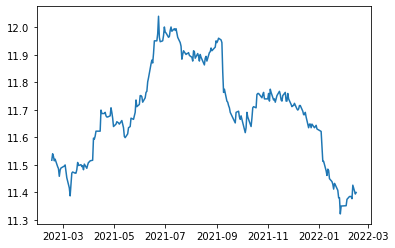

In [3]:
#로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

In [4]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
#이동평균 Function
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

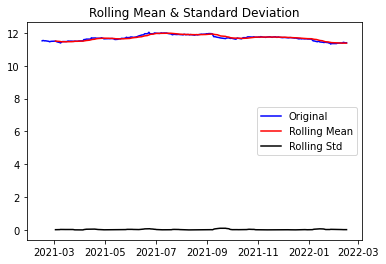

Results of Dickey-Fuller Test:
Test Statistic                  -1.585846
p-value                          0.490700
#Lags Used                       7.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


In [5]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

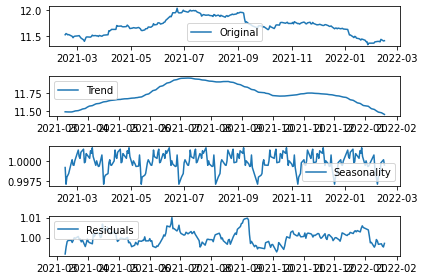

In [6]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [7]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.098202
p-value                          0.000975
#Lags Used                       3.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


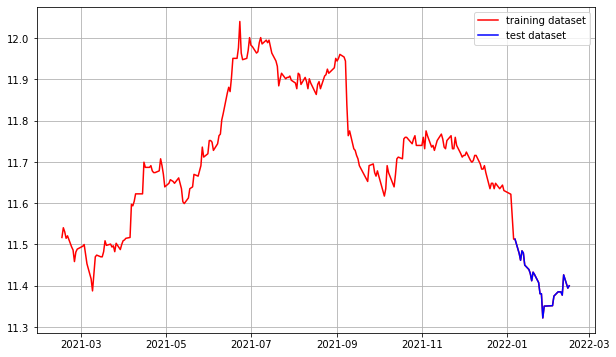

In [8]:
#데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


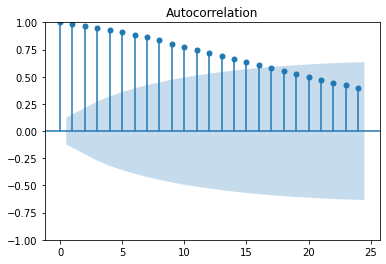

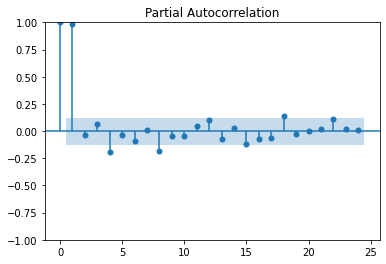

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -6.579536e+00
p-value                        7.575216e-09
#Lags Used                     3.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


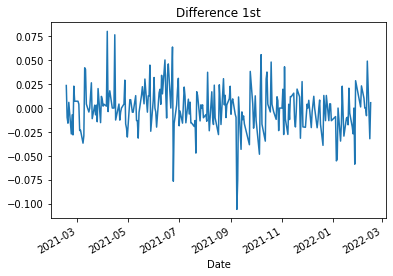

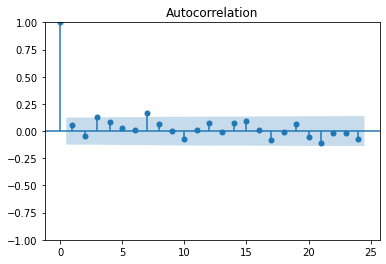

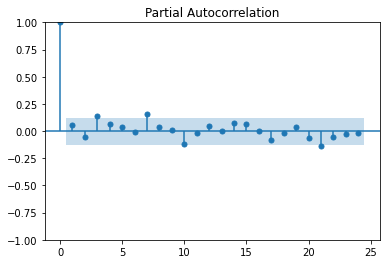

In [10]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.134662e+00
p-value                        3.445904e-10
#Lags Used                     1.300000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


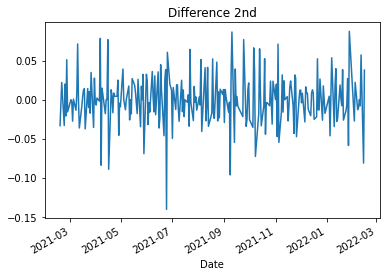

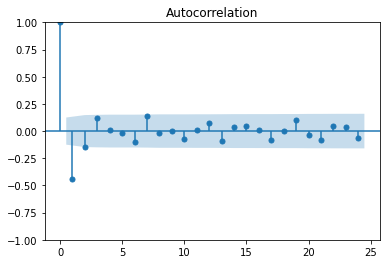

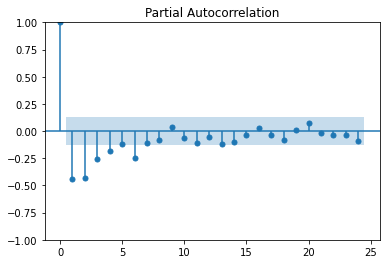

In [11]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [20]:
#ARIMA 모델 훈련
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model_1 = ARIMA(train_data, order=(0, 1, 17)) # P = ACF그래프에서 16번째 이후에는 절단값 아래로 내려가기 때문에
fitted_m = model_1.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                ARIMA(0, 1, 17)   Log Likelihood                 528.988
Date:                Tue, 15 Feb 2022   AIC                          -1021.976
Time:                        07:16:11   BIC                           -960.728
Sample:                             0   HQIC                          -997.248
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0732      0.054      1.356      0.175      -0.033       0.179
ma.L2         -0.1038      0.090     -1.155      0.248      -0.280       0.072
ma.L3          0.1393      0.076      1.839      0.0

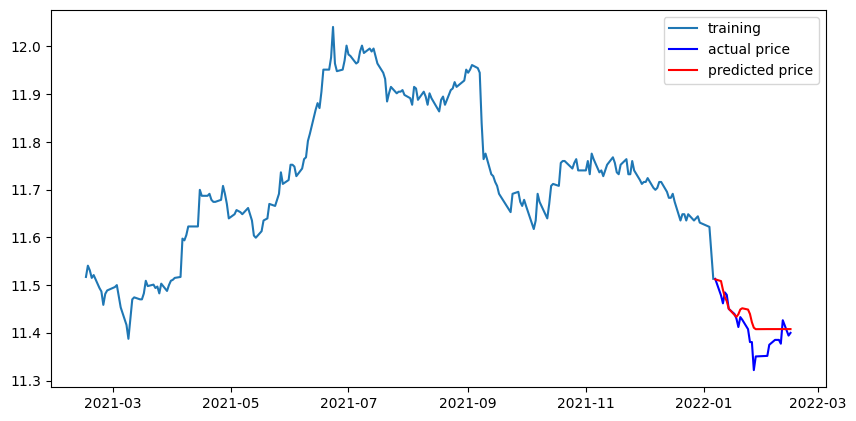

In [21]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  9160638.534541948
MAE:  2416.7205650416477
RMSE:  3026.654677121582
MAPE: 2.74%


In [44]:
dataset_filepath_1 = os.getenv('HOME') + '/aiffel/stock_prediction/data/AMD.csv'
df_1 = pd.read_csv(dataset_filepath_1, index_col='Date', parse_dates=True)
ts_1 = df_1['Close']

ts_1.head()

Date
2021-02-16    91.459999
2021-02-17    89.940002
2021-02-18    88.639999
2021-02-19    89.580002
2021-02-22    85.370003
Name: Close, dtype: float64

In [45]:
#결측치 처리
ts_1 = ts_1.interpolate(method = 'time')
ts_1[ts_1.isna()]

Series([], Name: Close, dtype: float64)

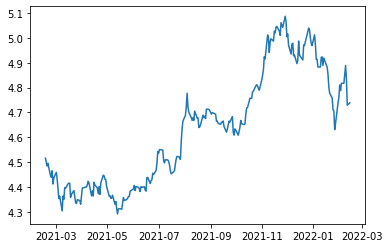

In [46]:
#로그 변환
ts_log_1 = np.log(ts_1)
plt.plot(ts_log_1)

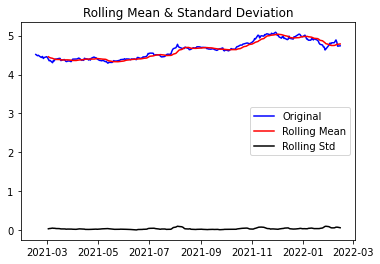

Results of Dickey-Fuller Test:
Test Statistic                  -1.029190
p-value                          0.742469
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [47]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log_1, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_1)

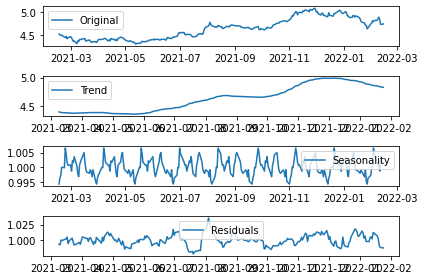

In [49]:
decomposition_1 = seasonal_decompose(ts_log_1, model='multiplicative', period = 30) 

trend_1 = decomposition_1.trend
seasonal_1 = decomposition_1.seasonal
residual_1 = decomposition_1.resid

plt.subplot(411)
plt.plot(ts_log_1, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_1, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_1,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_1, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [50]:
residual_1.dropna(inplace=True)
augmented_dickey_fuller_test(residual_1)

Results of Dickey-Fuller Test:
Test Statistic                -5.832733e+00
p-value                        3.940443e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.130000e+02
Critical Value (1%)           -3.461429e+00
Critical Value (5%)           -2.875207e+00
Critical Value (10%)          -2.574054e+00
dtype: float64


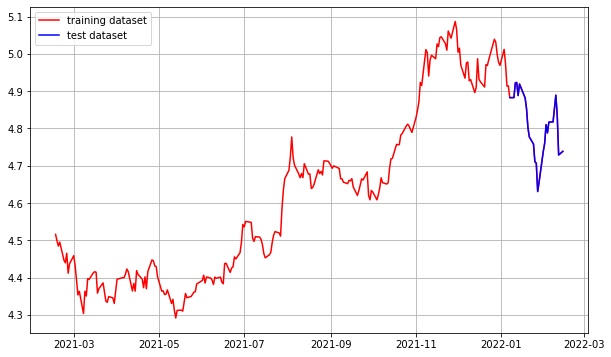

In [51]:
train_data_1, test_data_1 = ts_log_1[:int(len(ts_log_1)*0.9)], ts_log_1[int(len(ts_log_1)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log_1, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data_1, c='b', label='test dataset')
plt.legend()

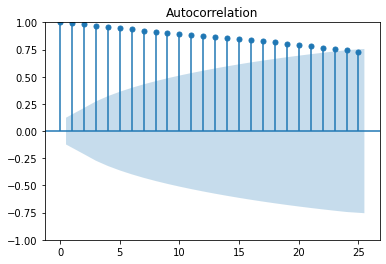

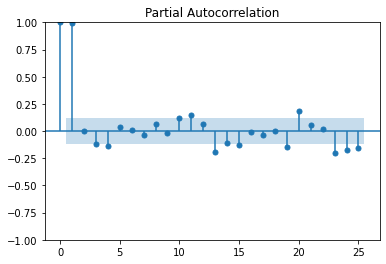

In [52]:
plot_acf(ts_log_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.589532e+01
p-value                        8.448850e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


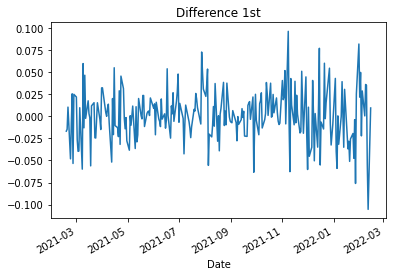

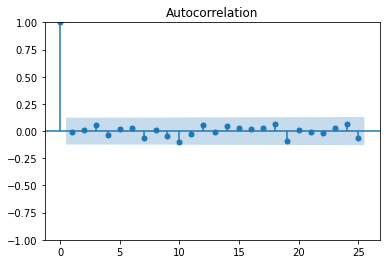

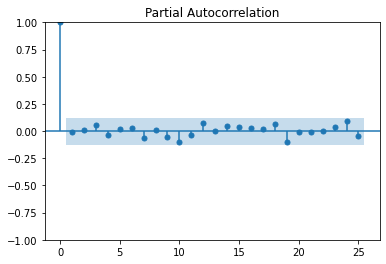

In [53]:
diff_3 = ts_log_1.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_3)

plot_acf(diff_3)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_3)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.194738e+00
p-value                        2.451311e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


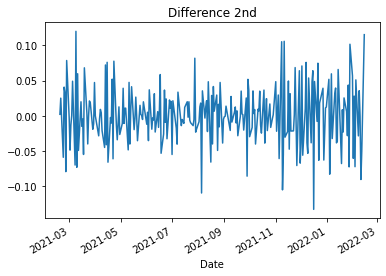

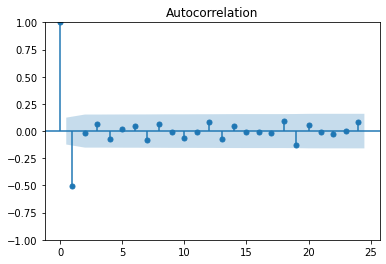

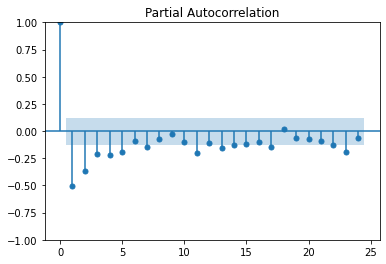

In [54]:
# 혹시 필요한 경우 2차 차분 구하기
diff_4 = diff_3.diff(periods=1).iloc[1:]
diff_4.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_4)

plot_acf(diff_4)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_4)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [64]:
model_2 = ARIMA(train_data_1, order=(1, 1, 0)) # P = PACF그래프에서 1번째 이후에는 절단값 아래로 내려가기 때문에
fitted_m_1 = model_2.fit() 

print(fitted_m_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 493.006
Date:                Tue, 15 Feb 2022   AIC                           -982.012
Time:                        09:25:35   BIC                           -975.170
Sample:                             0   HQIC                          -979.251
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0606      0.067     -0.907      0.365      -0.192       0.070
sigma2         0.0007   6.22e-05     11.995      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

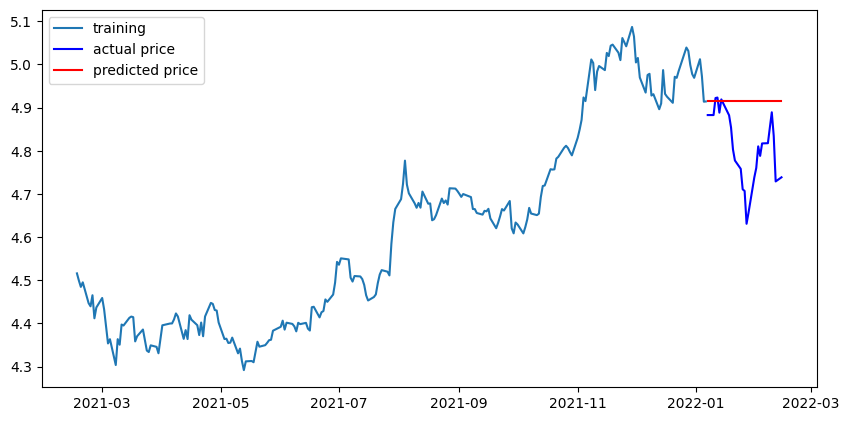

In [65]:
# Forecast : 결과가 fc에 담깁니다. 
fc_1 = fitted_m_1.forecast(len(test_data_1), alpha=0.05)  # 95% conf
fc_1 = np.array(fc_1)
# Make as pandas series
fc_series_1 = pd.Series(fc_1, index=test_data_1.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_1, label='training')
plt.plot(test_data_1, c='b', label='actual price')
plt.plot(fc_series_1, c='r',label='predicted price')
plt.legend()
plt.show()

In [66]:
mse_1 = mean_squared_error(np.exp(test_data_1), np.exp(fc_1))
print('MSE: ', mse_1)

mae_1 = mean_absolute_error(np.exp(test_data_1), np.exp(fc_1))
print('MAE: ', mae_1)

rmse_1 = math.sqrt(mean_squared_error(np.exp(test_data_1), np.exp(fc_1)))
print('RMSE: ', rmse_1)

mape_1 = np.mean(np.abs(np.exp(fc_1) - np.exp(test_data_1))/np.abs(np.exp(test_data_1)))
print('MAPE: {:.2f}%'.format(mape_1*100))

MSE:  278.46972009817694
MAE:  13.749441670457294
RMSE:  16.687412025181644
MAPE: 11.91%


In [69]:
dataset_filepath_2 = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df_2 = pd.read_csv(dataset_filepath_2, index_col='Date', parse_dates=True)
ts_2 = df_2['Close']

ts_2.head()

Date
2021-02-16    133.190002
2021-02-17    130.839996
2021-02-18    129.710007
2021-02-19    129.869995
2021-02-22    126.000000
Name: Close, dtype: float64

In [74]:
#결측치 처리
ts_2 = ts_2.interpolate(method = 'time')
ts_2[ts_2.isna()]

Series([], Name: Close, dtype: float64)

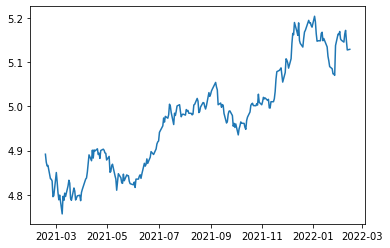

In [75]:
#로그 변환
ts_log_2 = np.log(ts_2)
plt.plot(ts_log_2)

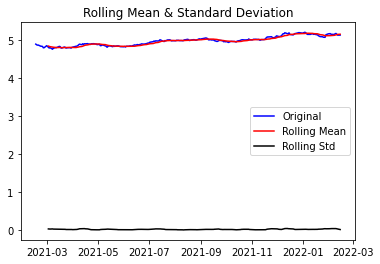

Results of Dickey-Fuller Test:
Test Statistic                  -0.745642
p-value                          0.834570
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [76]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log_2, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_2)

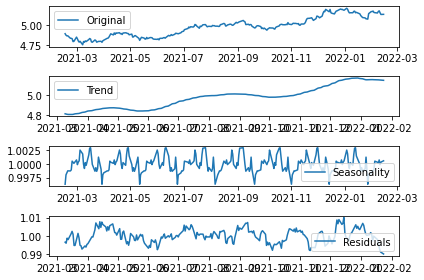

In [77]:
decomposition_2 = seasonal_decompose(ts_log_2, model='multiplicative', period = 30) 

trend_2 = decomposition_2.trend
seasonal_2 = decomposition_2.seasonal
residual_2 = decomposition_2.resid

plt.subplot(411)
plt.plot(ts_log_2, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_2, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_2,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_2, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [78]:
residual_1.dropna(inplace=True)
augmented_dickey_fuller_test(residual_1)

Results of Dickey-Fuller Test:
Test Statistic                -5.832733e+00
p-value                        3.940443e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.130000e+02
Critical Value (1%)           -3.461429e+00
Critical Value (5%)           -2.875207e+00
Critical Value (10%)          -2.574054e+00
dtype: float64


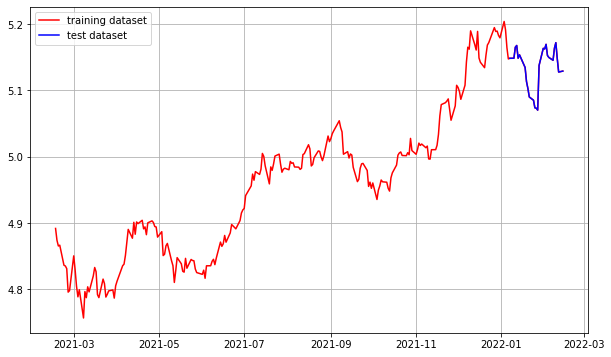

In [81]:
train_data_2, test_data_2 = ts_log_2[:int(len(ts_log_2)*0.9)], ts_log_2[int(len(ts_log_2)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log_2, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data_2, c='b', label='test dataset')
plt.legend()

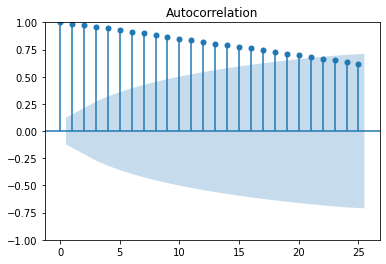

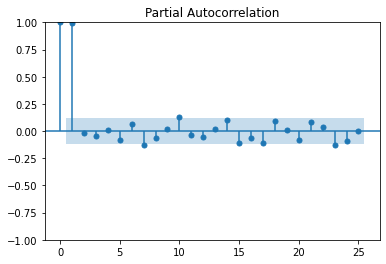

In [82]:
plot_acf(ts_log_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.607467e+01
p-value                        5.459468e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


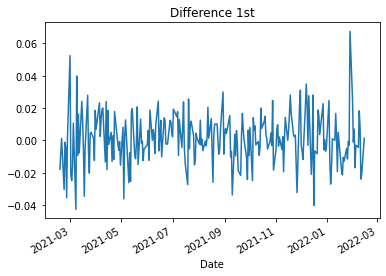

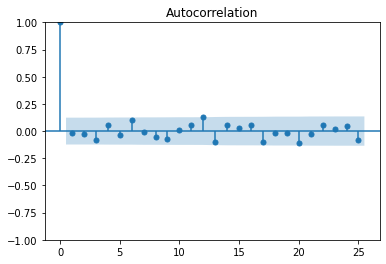

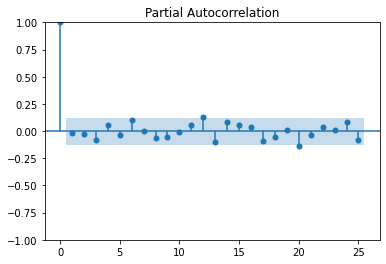

In [83]:
diff_5 = ts_log_2.diff(periods=1).iloc[1:]
diff_5.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_5)

plot_acf(diff_5)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_5)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.589324e+00
p-value                        2.556258e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


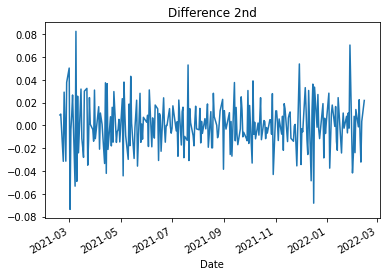

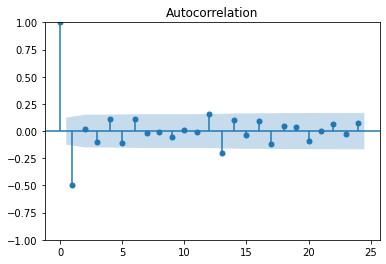

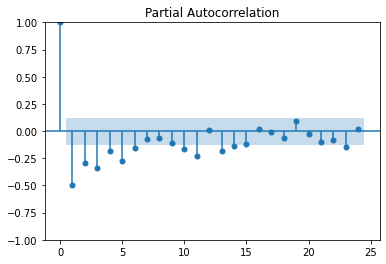

In [91]:
# 혹시 필요한 경우 2차 차분 구하기
diff_6 = diff_5.diff(periods=1).iloc[1:]
diff_6.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_6)

plot_acf(diff_6)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_6)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [105]:
model_3 = ARIMA(train_data_2, order=(0, 1, 0)) # Q = PACF그래프에서 1번째 이후에는 절단값 아래로 내려가기 때문에
fitted_m_2 = model_3.fit() 

print(fitted_m_2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 623.915
Date:                Tue, 15 Feb 2022   AIC                          -1245.830
Time:                        10:26:58   BIC                          -1242.410
Sample:                             0   HQIC                         -1244.450
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002   2.02e-05     11.575      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):                 1.92
Prob(Q):                              0.31   Pr

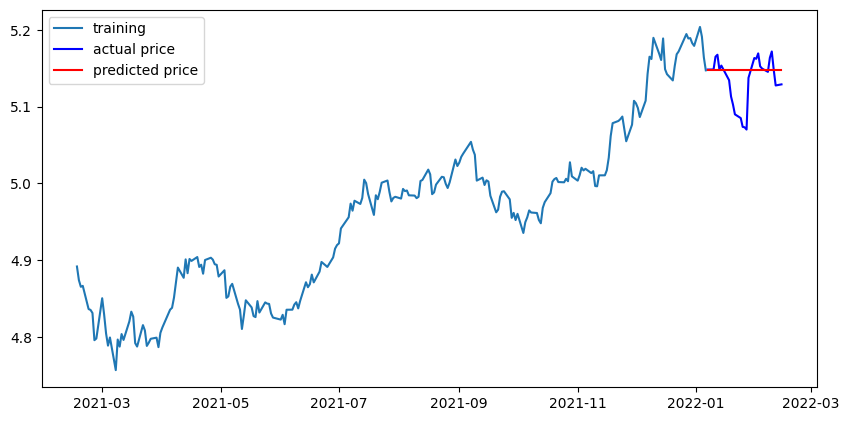

In [106]:
# Forecast : 결과가 fc에 담깁니다. 
fc_2 = fitted_m_2.forecast(len(test_data_2), alpha=0.05)  # 95% conf
fc_2 = np.array(fc_2)
# Make as pandas series
fc_series_2 = pd.Series(fc_2, index=test_data_2.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_2, label='training')
plt.plot(test_data_2, c='b', label='actual price')
plt.plot(fc_series_2, c='r',label='predicted price')
plt.legend()
plt.show()

In [107]:
mse_2 = mean_squared_error(np.exp(test_data_2), np.exp(fc_2))
print('MSE: ', mse_2)

mae_2 = mean_absolute_error(np.exp(test_data_2), np.exp(fc_2))
print('MAE: ', mae_2)

rmse_2 = math.sqrt(mean_squared_error(np.exp(test_data_2), np.exp(fc_2)))
print('RMSE: ', rmse_2)

mape_2 = np.mean(np.abs(np.exp(fc_2) - np.exp(test_data_1))/np.abs(np.exp(test_data_2)))
print('MAPE: {:.2f}%'.format(mape_2*100))

MSE:  33.148081950011004
MAE:  4.12346115384615
RMSE:  5.757437099092877
MAPE: 29.15%


p :0 d : 2 q : 0
MAPE: 11.14%


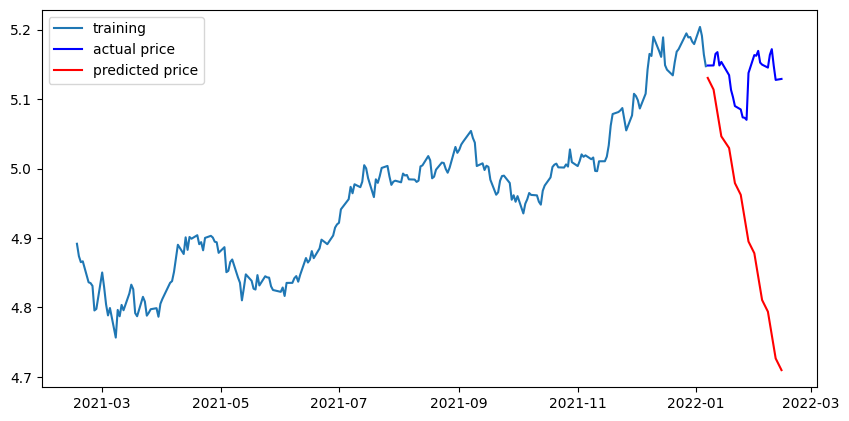

p :1 d : 2 q : 0
MAPE: 10.74%


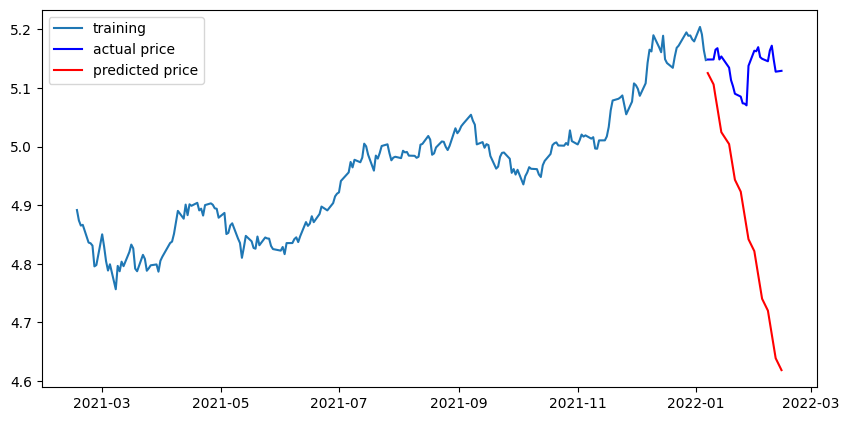

p :2 d : 2 q : 0
MAPE: 10.77%


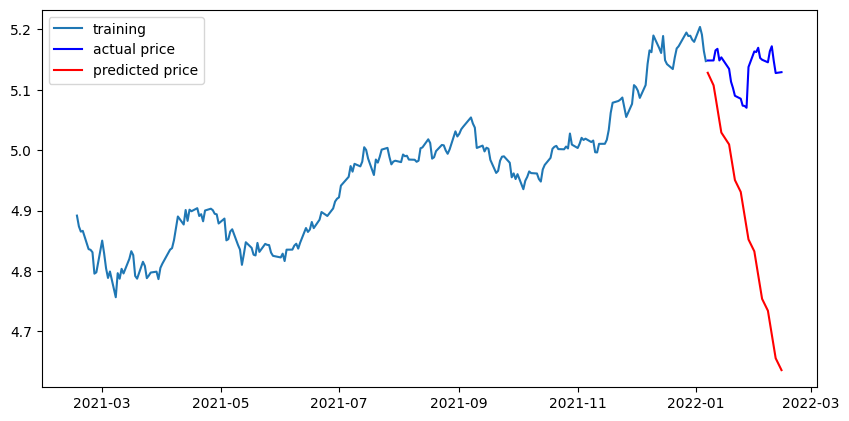

p :3 d : 2 q : 0
MAPE: 13.81%


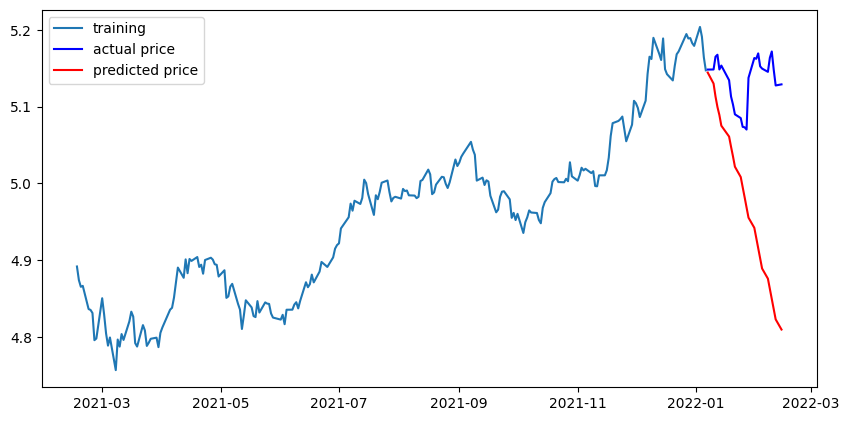

In [110]:
for p in range(25):
    for d in range(1, 3):
        for q in range(25):
            model_3 = ARIMA(train_data_2, order=(p, d, q))
            fitted_m_2 = model_3.fit()
            fc_2 = fitted_m_2.forecast(len(test_data_2), alpha=0.05)  # 95% conf
            fc_2 = np.array(fc_2)
            fc_series_2 = pd.Series(fc_2, index=test_data_2.index)   # 예측결과
            mape_2 = np.mean(np.abs(np.exp(fc_2) - np.exp(test_data_1))/np.abs(np.exp(test_data_2)))
            if mape_2*100 < 15:
                print('p :{0} d : {1} q : {2}'.format(p,d,q))
                print('MAPE: {:.2f}%'.format(mape_2*100))
                plt.figure(figsize=(10,5), dpi=100)
                plt.plot(train_data_2, label='training')
                plt.plot(test_data_2, c='b', label='actual price')
                plt.plot(fc_series_2, c='r',label='predicted price')
                plt.legend()
                plt.show()